In [11]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [14]:
data_dir = Path.cwd().parent / "data"

df = pd.read_csv(data_dir / "crsp_compustat_raw.csv", parse_dates=["MthCalDt"])
df["YYYYMM"] = df["MthCalDt"].dt.to_period("M").astype(str)

crsp = pd.read_csv(data_dir / "crsp_raw.csv", parse_dates=["date"])
crsp["YYYYMM"] = crsp["date"].dt.to_period("M").astype(str)

df = df.merge(
    crsp[["PERMNO", "YYYYMM", "SHRCD", "EXCHCD"]], on=["PERMNO", "YYYYMM"], how="left"
)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327144 entries, 0 to 327143
Data columns (total 43 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   gvkey            327144 non-null  int64         
 1   datadate         327144 non-null  object        
 2   fyear            327144 non-null  int64         
 3   indfmt           327144 non-null  object        
 4   consol           327144 non-null  object        
 5   popsrc           327144 non-null  object        
 6   datafmt          327144 non-null  object        
 7   tic              327141 non-null  object        
 8   cusip            327144 non-null  object        
 9   conm             327144 non-null  object        
 10  curcd            327144 non-null  object        
 11  fyr              327144 non-null  int64         
 12  at               304833 non-null  float64       
 13  ceq              301653 non-null  float64       
 14  csho             325

In [16]:
df.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,...,MthCap,MthRet,MthRetx,SecurityType,SecuritySubType,ShareType,PrimaryExch,ShrOut,SHRCD,EXCHCD
0,1000,1970-12-31,1970,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,21903.75,-0.043478,-0.043478,EQTY,COM,NS,A,2655.0,10.0,2.0
1,1000,1971-12-31,1971,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,15930.00,-0.094340,-0.094340,EQTY,COM,NS,A,2655.0,10.0,2.0
2,1000,1972-12-31,1972,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,7965.00,-0.040000,-0.040000,EQTY,COM,NS,A,2655.0,10.0,2.0
3,1000,1973-12-31,1973,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,6969.38,0.050000,0.050000,EQTY,COM,NS,A,2655.0,10.0,2.0
4,1000,1974-12-31,1974,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,6201.06,0.146341,0.146341,EQTY,COM,NS,A,2111.0,10.0,2.0


In [17]:
# FINAL PAPERS FILTERS:
df = df[df["SHRCD"].isin([10, 11])]  # common stock only
df = df[df["EXCHCD"].isin([1, 2, 3])]  # NYSE/AMEX/NASDAQ
df = df[(df["SICCD"] < 6000) | (df["SICCD"] > 6799)]  # no finance/insurance/REIT

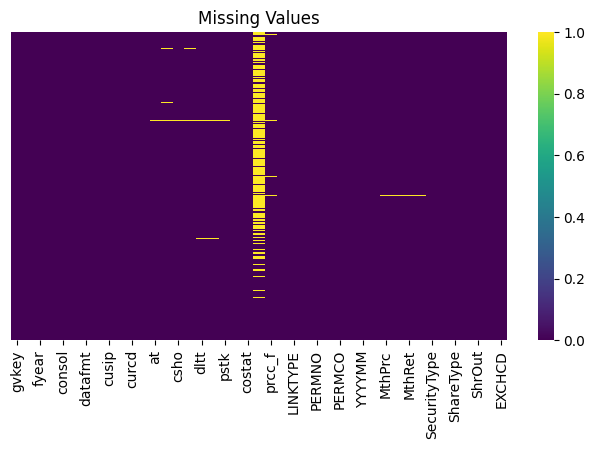

In [18]:
plt.figure(figsize=(8, 4))
sns.heatmap(df.isnull(), cbar=True, cmap="viridis", yticklabels=False)
plt.title("Missing Values")
plt.show()